## Code for solving the matching problem.

We need to define four fields which will evolve with the RK scheme.

For the left region we have 3 fields, $\phi_L$, $vp$ and $vm$
For the right region also solve for 3 fields, $S$, $W$, and $\phi_R$.





In [268]:
using Plots
using FileIO
using JLD2
using Base.Threads
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
using LaTeXStrings

nthreads = 2


In [269]:
include("aux_functions.jl")

bump_x (generic function with 1 method)

In [270]:
l_pulse = false
r_pulse = false
r_pulse = true

if l_pulse
    run_name = "l_pulse_"
end
if r_pulse
    run_name = "r_pulse_"
end

Nl = 401; Nr = 401 #points to the left and rigth regions
L = 1.0 #size of left side 
R = 1.0 #size of right side
dl = L/(Nl-1)
dr = R/(Nr-1)
u = zeros(3Nl+3Nr);
ρ_L = zeros(Nl)
ρ_R = zeros(Nr) 

run_name = run_name * "$(Nl)_$(Nr)"
par_grid = (Nl, L, dl, Nr, R, dr)

(401, 1.0, 0.0025, 401, 1.0, 0.0025)

### The initial data. 

We shall use first a simple initial data consisting of a bump to the left in the right side. The rest is zero.

In [271]:




if r_pulse
    S = view(u,3Nl+Nr+1:3Nl+2Nr)
    ϕ_R = view(u,3Nl+1:3Nl+Nr)
    x0 = L + 0.2
    x1 = L + 0.4
    p_bump = 4
    A = 1.0
    for i in 1:Nr 
        r = L + dr*(i-1) 
        S[i] = bump_x(r,x0,x1,p_bump,A)
        ϕ_R[i] = bump(r,x0,x1,p_bump,A)
        plot(S)
    end
end

if l_pulse

    x0 =  0.6
    x1 =  0.8
    p_bump = 4
    A = 1.0

    vp = view(u,Nl+1:2Nl)
    ϕ_L = view(u,1:Nl)

    for i in 1:Nl
        r = dl*(i-1) 
        #u[3*Nl+Nr+i] = bump(r,x0,x1,p_bump,A)
        vp[i] = 2*bump_x(r,x0,x1,p_bump,A)
        ϕ_L[i] = bump(r,x0,x1,p_bump,A)
        plot(ϕ_L)
    end
end
par_init = (x0,x1,p_bump,A)



(1.2, 1.4, 4, 1.0)

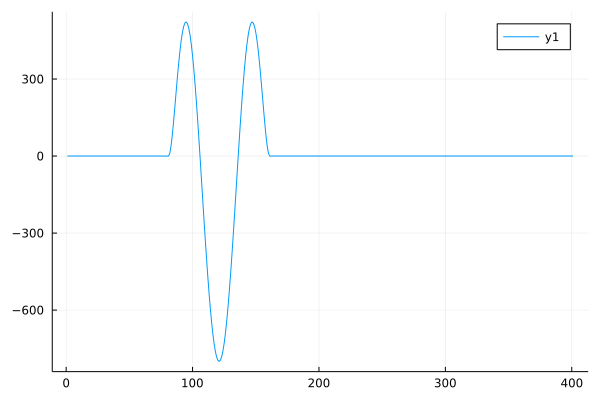

In [272]:
par_Dx_r = (Nr, dr)
dS = D4x_SBP_ts(S,par_Dx_r,Qd)
plot(dS)

In [273]:
ρ_L = zeros(Nl)
ρ_R = zeros(Nr)
du = zeros(3Nl+3Nr)

p_F = Nl, dl, Nr, dr, ρ_L, ρ_R

(401, 0.0025, 401, 0.0025, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [274]:
t_i = 0.0
if l_pulse
    t_f = 2.0
    M = 1601
    dt = (t_f - t_i)/(M-1)
    M_d = 101
end
if r_pulse
    t_f = 3.0
    M = 1801
    dt = (t_f - t_i)/(M-1)
    M_d = 151
end
t = t_i
dt_d = (t_f - t_i)/(M_d-1)

0.02

In [275]:
k1 = zeros(3Nl+3Nr)
k2 = zeros(3Nl+3Nr)
k3 = zeros(3Nl+3Nr)
k4 = zeros(3Nl+3Nr)
par_RK = (k1, k2, k3, k4)
par_evolv = (t_i, t_f, M, dt, M_d, dt_d)

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "par_init" => par_init)
file_name = "Results/"* run_name * ".jld2"
#rm(file_name)
j = 1
tiempo = @sprintf("%05d", j)
field_name = "u"

save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

jldopen(file_name, "a+") do file
    file[field_name * "/u_$(tiempo)"] = u;
end

2406-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [276]:


for k in 2:M
    RK4_Step!(F!,u,t,dt,p_F,par_RK)
    global t = t + dt
    if (k-1) % (M÷(M_d-1)) == 0
        local j = (k-1)÷(M÷(M_d-1))+1
        local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
        end
        println("t=$t")
    end
end


t=0.02
t=0.03999999999999999
t=0.05999999999999995
t=0.07999999999999992
t=0.09999999999999988
t=0.11999999999999984
t=0.13999999999999993
t=0.16000000000000006
t=0.1800000000000002
t=0.20000000000000032
t=0.22000000000000045
t=0.24000000000000057
t=0.2600000000000005
t=0.2800000000000003
t=0.3000000000000001
t=0.3199999999999999
t=0.3399999999999997
t=0.3599999999999995
t=0.3799999999999993
t=0.3999999999999991
t=0.4199999999999989
t=0.43999999999999867
t=0.45999999999999847
t=0.47999999999999826
t=0.49999999999999806
t=0.5199999999999985
t=0.5399999999999989
t=0.5599999999999994
t=0.5799999999999998
t=0.6000000000000003
t=0.6200000000000008
t=0.6400000000000012
t=0.6600000000000017
t=0.6800000000000022
t=0.7000000000000026
t=0.7200000000000031
t=0.7400000000000035
t=0.760000000000004
t=0.7800000000000045
t=0.8000000000000049
t=0.8200000000000054
t=0.8400000000000059
t=0.8600000000000063
t=0.8800000000000068
t=0.9000000000000072
t=0.9200000000000077
t=0.9400000000000082
t=0.9600000000